<a href="https://colab.research.google.com/github/Louizaait/Seasonal-Quantile-Forecasting-of-Solar-Photovoltaic-Power-using-Q-CNN-GRU-/blob/main/Q_CNN_GRU_(China).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import the necessary libraries

In [2]:
%%capture
pip install pysolar pvlib properscoring

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import os
import plotly.graph_objects as go
import joblib

from sklearn.preprocessing import MinMaxScaler

from tensorflow import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, load_model
from keras.layers import GRU, Dense, Flatten, LSTM, Conv1D, MaxPooling1D,Input

from pysolar.solar import get_altitude, get_azimuth
from pvlib.location import Location
from pvlib.solarposition import get_solarposition
import pytz
import pvlib

from tensorflow_probability import distributions as tfd
from tensorflow_probability import layers as tfpl
import tensorflow as tf
from tensorflow.keras import backend as K
import properscoring as ps
from scipy import stats


Import the data

In [7]:
from google.colab import files
FILES=files.upload()

Saving station00.csv to station00.csv
Saving station01.csv to station01 (1).csv
Saving station02.csv to station02 (1).csv


Univaraite forecast using Q-CNN-GRU, Q-GRU, Q-LSTM

In [59]:

stations = {
    "station00": {"file": "station00.csv", "latitude": 38.04778, "longitude": 114.95139},
    "station01": {"file": "station01.csv", "latitude": 38.18306, "longitude": 117.45722},
    "station02": {"file": "station02.csv", "latitude": 38.05728, "longitude": 114.19887},
}

# Function to process each station
def process_station(file, latitude, longitude):
    # Load and preprocess data
    df = pd.read_csv(file)
    df['date_time'] = pd.to_datetime(df['date_time'])  # Convert to datetime
    df.set_index('date_time', inplace=True)  # Set datetime as index

    # Resample data to 1-hour intervals and calculate mean
    df_resampled = df.resample('1h').mean()

    # Calculate solar zenith angle
    location = Location(latitude=latitude, longitude=longitude, tz='UTC')
    solar_position = get_solarposition(df_resampled.index, latitude=latitude, longitude=longitude)

    # Add solar zenith angle and filter for zenith < 85
    df_resampled['Solar_Zenith'] = solar_position['zenith']
    df_filtered = df_resampled[df_resampled['Solar_Zenith'] < 85]

    # Fill missing values and reset index
    df_filtered = df_filtered.fillna(method='bfill').reset_index()

    return df_filtered

# Process all stations
processed_stations = {}
for station_name, station_info in stations.items():
    processed_stations[station_name] = process_station(
        file=station_info["file"],
        latitude=station_info["latitude"],
        longitude=station_info["longitude"],
    )

# Access processed data for each station
station00_data = processed_stations["station00"]
station01_data = processed_stations["station01"]
station02_data = processed_stations["station02"]


# Normalize power values by dividing with the nominal power
train = station00_data[["date_time", "power"]]
val = station01_data[["date_time", "power"]]
test = station02_data[["date_time", "power"]]

# Nominal power values in MW for each station
nominal_power_MW_02 =17
nominal_power_MW_01 = 20
nominal_power_MW_00 = 6.600

train['power'] = train['power'] / nominal_power_MW_00
val['power'] = val['power'] / nominal_power_MW_01
test['power'] = test['power'] / nominal_power_MW_02

# Define the seasons based on the 'DateTime' column
spring = test['date_time'].dt.month.isin([3, 4, 5])
summer = test['date_time'].dt.month.isin([6, 7, 8])
autumn = test['date_time'].dt.month.isin([9, 10, 11])
winter = test['date_time'].dt.month.isin([12, 1, 2])

# Split the test data into seasons
spring_data = test[spring]
summer_data = test[summer]
autumn_data = test[autumn]
winter_data = test[winter]


# Scaling
scaler = MinMaxScaler().fit(train[['power']])
joblib.dump(scaler, 'scaler.gz')

def scale_samples(data, scaler):
    data_scaled = data.copy()
    data_scaled['power'] = scaler.transform(data[['power']])
    return data_scaled

train = scale_samples(train, scaler)
val = scale_samples(val, scaler)
test = scale_samples(winter_data, scaler)

# Multi-step Data Preparation
def shift_samples_multi_step(data, lookback=48, steps_ahead=1):
    data_x, data_y = [], []
    power_values = data['power'].values

    for i in range(len(power_values) - lookback - steps_ahead):
        data_x.append(power_values[i:i + lookback].reshape(-1, 1))
        data_y.append(power_values[i + lookback:i + lookback + steps_ahead])
    return np.array(data_x), np.array(data_y)

steps_ahead = 1
x_train, y_train = shift_samples_multi_step(train, lookback=48, steps_ahead=steps_ahead)
x_val, y_val = shift_samples_multi_step(val, lookback=48, steps_ahead=steps_ahead)
x_test, y_test = shift_samples_multi_step(test, lookback=48, steps_ahead=steps_ahead)

# Define Pinball Loss
def single_quantile_loss(tau=0.5):
    def loss(y_true, y_pred):
        err = y_true - y_pred
        return K.mean(K.maximum(tau * err, (tau - 1) * err), axis=-1)
    return loss

quantiles = np.round(np.linspace(0.01, 0.99, 99), 2)

# Model Architecture
inputs = Input(shape=(x_train.shape[1], 1))

x = Conv1D(22, 4, activation='relu', padding='same')(inputs)
x = MaxPooling1D(1)(x)
x = Conv1D(22, 4, activation='relu', padding='same')(x)
x = GRU(31, dropout=0.1)(x)
x = Flatten()(x)

"""
x = GRU(64, return_sequences=True, dropout=0.2)(inputs)  # First GRU layer
x = GRU(32, dropout=0.2)(x)  # Second GRU layer
"""
"""
x = LSTM(64, return_sequences=True, dropout=0.2)(inputs)  # First LSTM layer
x = LSTM(32, dropout=0.2)(x)  # Second LSTM layer
"""
outputs = {f'quantile_{tau:.2f}': Dense(steps_ahead, name=f'quantile_{tau:.2f}')(x) for tau in quantiles}

model =keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    loss={f'quantile_{tau:.2f}': single_quantile_loss(tau) for tau in quantiles},
    optimizer='adam'
)

# Training
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history2 = model.fit(
    x_train,
    {f'quantile_{tau:.2f}': y_train for tau in quantiles},
    validation_data=(x_val, {f'quantile_{tau:.2f}': y_val for tau in quantiles}),
    epochs=30,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1,
    shuffle=False
)

# Prediction and Evaluation
pred_test = model.predict(x_test)
pred_test = {tau: scaler.inverse_transform(pred_test[f'quantile_{tau:.2f}']) for tau in quantiles}
y_test = scaler.inverse_transform(y_test)

y_pred_ensemble = np.dstack([pred_test[tau] for tau in quantiles])
crps_scores = [
    np.mean(ps.crps_ensemble(np.nan_to_num(y_test[:, step]), np.nan_to_num(y_pred_ensemble[:, step, :])))
    for step in range(steps_ahead)
]

crps_scores = np.array(crps_scores) # Normalize CRPS
print("CRPS Scores for each step:", crps_scores)
print("Mean Normalized CRPS Score:", np.mean(crps_scores))

<ipython-input-59-868b71ec6ffb>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filtered = df_filtered.fillna(method='bfill').reset_index()
<ipython-input-59-868b71ec6ffb>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filtered = df_filtered.fillna(method='bfill').reset_index()
<ipython-input-59-868b71ec6ffb>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filtered = df_filtered.fillna(method='bfill').reset_index()
<ipython-input-59-868b71ec6ffb>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

Epoch 1/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 72s 194ms/step - loss: 13.9881 - quantile_0.01_loss: 0.0043 - quantile_0.02_loss: 0.0106 - quantile_0.03_loss: 0.0147 - quantile_0.04_loss: 0.0158 - quantile_0.05_loss: 0.0257 - quantile_0.06_loss: 0.0221 - quantile_0.07_loss: 0.0276 - quantile_0.08_loss: 0.0319 - quantile_0.09_loss: 0.0327 - quantile_0.10_loss: 0.0400 - quantile_0.11_loss: 0.0363 - quantile_0.12_loss: 0.0485 - quantile_0.13_loss: 0.0838 - quantile_0.14_loss: 0.0524 - quantile_0.15_loss: 0.0591 - quantile_0.16_loss: 0.0918 - quantile_0.17_loss: 0.0692 - quantile_0.18_loss: 0.0687 - quantile_0.19_loss: 0.0718 - quantile_0.20_loss: 0.0714 - quantile_0.21_loss: 0.0671 - quantile_0.22_loss: 0.0872 - quantile_0.23_loss: 0.0763 - quantile_0.24_loss: 0.0778 - quantile_0.25_loss: 0.0878 - quantile_0.26_loss: 0.0990 - quantile_0.27_loss: 0.0944 - quantile_0.28_loss: 0.0826 - quantile_0.29_loss: 0.0987 - quantile_0.30_loss: 0.1446 - quantile_0.31_loss: 0.0914 - quantile_0.32_loss: 0.1034 - q

Reliability  diagram with Consistency bars

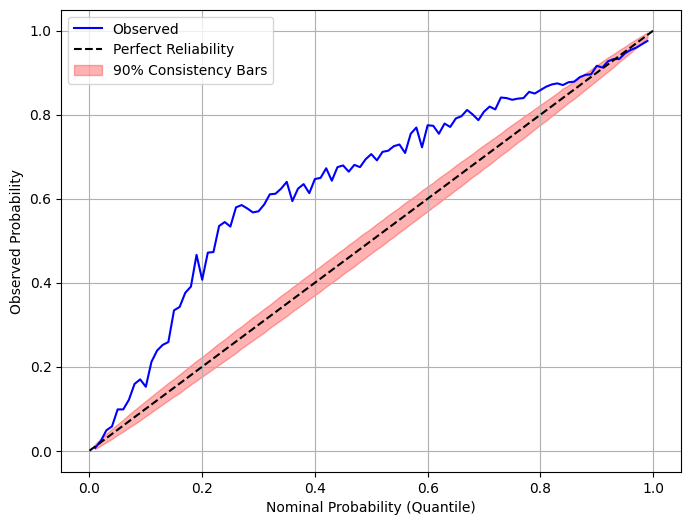

In [60]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import binom

# Calculate the observed probabilities for each quantile
def compute_observed_probabilities(y_true, y_pred, quantiles):
    observed_probabilities = []
    for tau in quantiles:
        # For each quantile, compute the proportion of observed values <= the predicted value
        observed_prob = np.mean(y_true <= y_pred[tau], axis=0)
        observed_probabilities.append(observed_prob)
    return np.array(observed_probabilities)

# Function to compute consistency bars
def compute_consistency_bars(quantiles, n_samples, confidence_level=0.90):
    lower_bounds = []
    upper_bounds = []
    alpha = 1 - confidence_level
    for q in quantiles:
        # Use binomial distribution to calculate bounds
        lower = binom.ppf(alpha / 2, n_samples, q) / n_samples
        upper = binom.ppf(1 - alpha / 2, n_samples, q) / n_samples
        lower_bounds.append(lower)
        upper_bounds.append(upper)
    return np.array(lower_bounds), np.array(upper_bounds)

#  y-test data)
n_samples = len(y_test)  # Number of samples in the test set

observed_probabilities = compute_observed_probabilities(y_test, pred_test, quantiles)

# Compute consistency bars
lower_bounds, upper_bounds = compute_consistency_bars(quantiles, n_samples)

# Plot reliability diagram with consistency bars
plt.figure(figsize=(8, 6))
plt.plot(quantiles, observed_probabilities, label='Observed', color='b')
plt.plot([0, 1], [0, 1], label='Perfect Reliability', linestyle='--', color='k')
plt.fill_between(quantiles, lower_bounds, upper_bounds, color='red', alpha=0.3, label='90% Consistency Bars')
plt.xlabel('Nominal Probability (Quantile)')
plt.ylabel('Observed Probability')

plt.legend()
plt.grid(True)
plt.show()


Sensitive Analysis

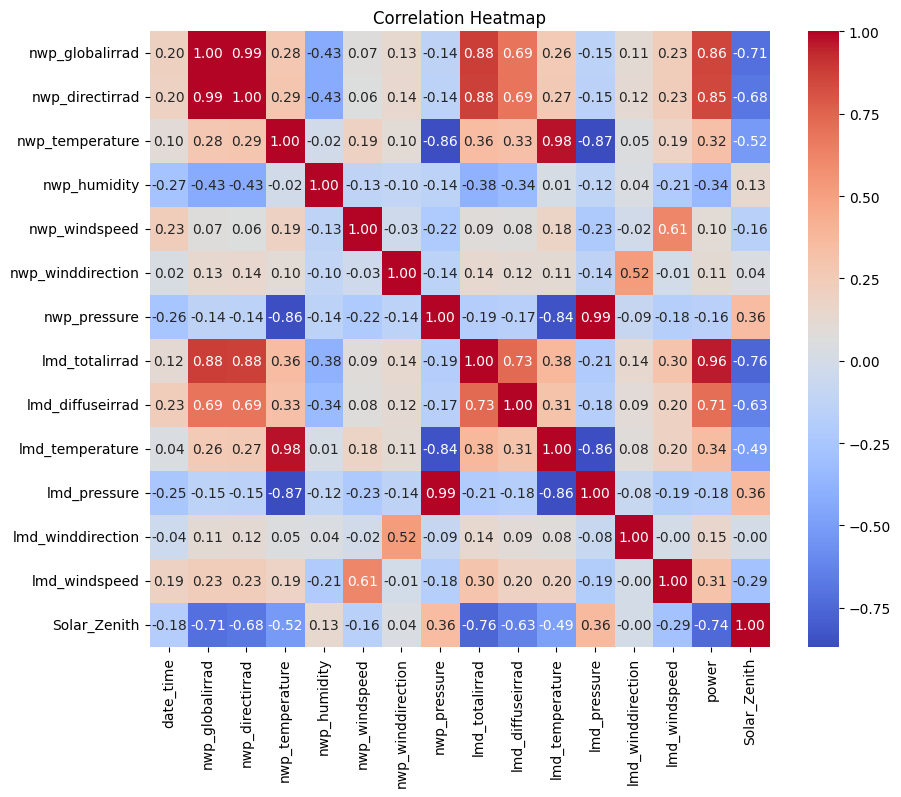

In [16]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix.drop(['power','date_time']) , annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


Multivaraite forecast using Q-CNN-GRU, Q-LSTM,Q-GRU

In [61]:
stations = {
    "station00": {"file": "station00.csv", "latitude": 38.04778, "longitude": 114.95139},
    "station01": {"file": "station01.csv", "latitude": 38.18306, "longitude": 117.45722},
    "station02": {"file": "station02.csv", "latitude": 38.05728, "longitude": 114.19887},
}

# Function to process each station
def process_station(file, latitude, longitude):
    # Load and preprocess data
    df = pd.read_csv(file)
    df['date_time'] = pd.to_datetime(df['date_time'])  # Convert to datetime
    df.set_index('date_time', inplace=True)  # Set datetime as index

    # Resample data to 1-hour intervals and calculate mean
    df_resampled = df.resample('1h').mean()

    # Calculate solar zenith angle
    location = Location(latitude=latitude, longitude=longitude, tz='UTC')
    solar_position = get_solarposition(df_resampled.index, latitude=latitude, longitude=longitude)

    # Add solar zenith angle and filter for zenith < 85
    df_resampled['Solar_Zenith'] = solar_position['zenith']
    df_filtered = df_resampled[df_resampled['Solar_Zenith'] < 85]

    # Fill missing values and reset index
    df_filtered = df_filtered.fillna(method='bfill').reset_index()

    return df_filtered

# Process all stations
processed_stations = {}
for station_name, station_info in stations.items():
    processed_stations[station_name] = process_station(
        file=station_info["file"],
        latitude=station_info["latitude"],
        longitude=station_info["longitude"],
    )

# Access processed data for each station
station00_data = processed_stations["station00"]
station01_data = processed_stations["station01"]
station02_data = processed_stations["station02"]


# Normalize power values by dividing with the nominal power
train = station00_data[['date_time','power', 'nwp_globalirrad', 'lmd_totalirrad']]

val = station01_data[['date_time','power', 'nwp_globalirrad','lmd_totalirrad' ]]
test = station02_data[['date_time','power', 'nwp_globalirrad' ,'lmd_totalirrad']]

# Nominal power values in MW for each station
nominal_power_MW_02 =17
nominal_power_MW_01 = 20
nominal_power_MW_00 = 6.600

train['power'] = train['power'] / nominal_power_MW_00
val['power'] = val['power'] / nominal_power_MW_01
test['power'] = test['power'] / nominal_power_MW_02

# Define the seasons based on the 'DateTime' column
spring = test['date_time'].dt.month.isin([3, 4, 5])
summer = test['date_time'].dt.month.isin([6, 7, 8])
autumn = test['date_time'].dt.month.isin([9, 10, 11])
winter = test['date_time'].dt.month.isin([12, 1, 2])

# Split the test data into seasons
spring_data = test[spring]
summer_data = test[summer]
autumn_data = test[autumn]
winter_data = test[winter]

# Scaling
scaler = MinMaxScaler().fit(train[['power', 'nwp_globalirrad','lmd_totalirrad']])
joblib.dump(scaler, 'scaler.gz')

def scale_samples(data, scaler):
    data_scaled = data.copy()
    data_scaled[['power', 'nwp_globalirrad', 'lmd_totalirrad']] = scaler.transform(data[['power', 'nwp_globalirrad',  'lmd_totalirrad']])
    return data_scaled

train = scale_samples(train, scaler)
val = scale_samples(val, scaler)
test = scale_samples(summer_data, scaler)

# Multi-step Data Preparation
def shift_samples_multi_step(data, lookback=48, steps_ahead=1):
    data_x, data_y = [], []
    power_values = data[['power', 'nwp_globalirrad','lmd_totalirrad']].values

    for i in range(len(power_values) - lookback - steps_ahead):
        data_x.append(power_values[i:i + lookback])
        data_y.append(power_values[i + lookback:i + lookback + steps_ahead, 0])  # Only 'power' as target
    return np.array(data_x), np.array(data_y)

steps_ahead = 1
x_train, y_train = shift_samples_multi_step(train, lookback=48, steps_ahead=steps_ahead)
x_val, y_val = shift_samples_multi_step(val, lookback=48, steps_ahead=steps_ahead)
x_test, y_test = shift_samples_multi_step(test, lookback=48, steps_ahead=steps_ahead)

# Define Pinball Loss
def single_quantile_loss(tau=0.5):
    def loss(y_true, y_pred):
        err = y_true - y_pred
        return K.mean(K.maximum(tau * err, (tau - 1) * err), axis=-1)
    return loss

quantiles = np.round(np.linspace(0.01, 0.99, 99), 2)

# Model Architecture
inputs = Input(shape=(x_train.shape[1], x_train.shape[2]))

x = Conv1D(22, 4, activation='relu', padding='same')(inputs)
x = MaxPooling1D(1)(x)
x = Conv1D(22, 4, activation='relu', padding='same')(x)
x = GRU(31, dropout=0.1)(x)
x = Flatten()(x)

outputs = {f'quantile_{tau:.2f}': Dense(steps_ahead, name=f'quantile_{tau:.2f}')(x) for tau in quantiles}

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    loss={f'quantile_{tau:.2f}': single_quantile_loss(tau) for tau in quantiles},
    optimizer='adam'
)

# Training
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history2 = model.fit(
    x_train,
    {f'quantile_{tau:.2f}': y_train for tau in quantiles},
    validation_data=(x_val, {f'quantile_{tau:.2f}': y_val for tau in quantiles}),
    epochs=30,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1,
    shuffle=False
)

# Prediction and Evaluation
pred_test = model.predict(x_test)
pred_test = {tau: pred_test[f'quantile_{tau:.2f}'][:, 0] for tau in quantiles}  # Only 'power'
y_test = y_test[:, 0]  # Access the first (and only) column of y_test
y_pred_ensemble = np.dstack([pred_test[tau] for tau in quantiles])
crps_scores = [
    np.mean(ps.crps_ensemble(np.nan_to_num(y_test), np.nan_to_num(y_pred_ensemble[0, :, :])))  # Access all samples and quantiles for the first (and only) time step
]
# Calculate the mean CRPS score over all samples - This is already done in the above line by using np.mean with ps.crps_ensemble
mean_crps_score = crps_scores[0]  # Access the calculated CRPS score
print("CRPS Scores for each step:", crps_scores)
print("Mean Normalized CRPS Score:", mean_crps_score)



<ipython-input-61-f1ee6ec17942>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filtered = df_filtered.fillna(method='bfill').reset_index()
<ipython-input-61-f1ee6ec17942>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filtered = df_filtered.fillna(method='bfill').reset_index()
<ipython-input-61-f1ee6ec17942>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filtered = df_filtered.fillna(method='bfill').reset_index()
<ipython-input-61-f1ee6ec17942>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

Epoch 1/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 77s 194ms/step - loss: 13.7086 - quantile_0.01_loss: 0.0041 - quantile_0.02_loss: 0.0092 - quantile_0.03_loss: 0.0111 - quantile_0.04_loss: 0.0554 - quantile_0.05_loss: 0.0192 - quantile_0.06_loss: 0.0241 - quantile_0.07_loss: 0.0281 - quantile_0.08_loss: 0.0329 - quantile_0.09_loss: 0.0314 - quantile_0.10_loss: 0.0366 - quantile_0.11_loss: 0.0396 - quantile_0.12_loss: 0.0433 - quantile_0.13_loss: 0.0475 - quantile_0.14_loss: 0.0484 - quantile_0.15_loss: 0.0486 - quantile_0.16_loss: 0.0578 - quantile_0.17_loss: 0.0567 - quantile_0.18_loss: 0.0613 - quantile_0.19_loss: 0.0746 - quantile_0.20_loss: 0.0632 - quantile_0.21_loss: 0.0747 - quantile_0.22_loss: 0.0824 - quantile_0.23_loss: 0.0832 - quantile_0.24_loss: 0.0995 - quantile_0.25_loss: 0.0711 - quantile_0.26_loss: 0.0808 - quantile_0.27_loss: 0.0875 - quantile_0.28_loss: 0.0915 - quantile_0.29_loss: 0.1050 - quantile_0.30_loss: 0.0950 - quantile_0.31_loss: 0.0937 - quantile_0.32_loss: 0.0956 - q

Reliability diagram with consistency bars

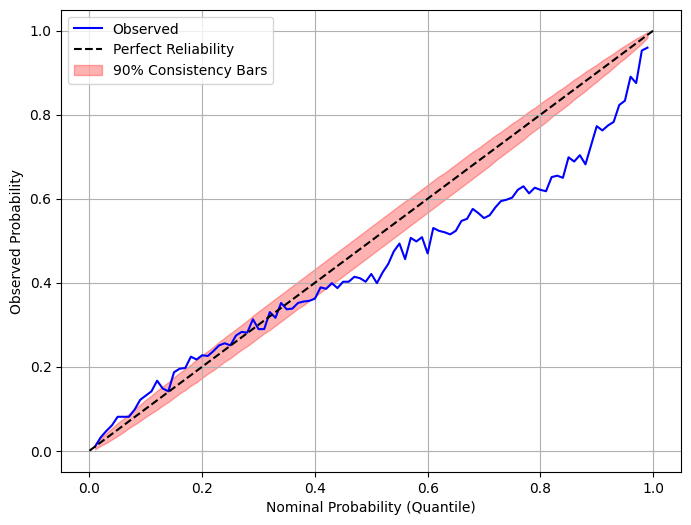

In [62]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import binom

# Calculate the observed probabilities for each quantile
def compute_observed_probabilities(y_true, y_pred, quantiles):
    observed_probabilities = []
    for tau in quantiles:
        # For each quantile, compute the proportion of observed values <= the predicted value
        observed_prob = np.mean(y_true <= y_pred[tau], axis=0)
        observed_probabilities.append(observed_prob)
    return np.array(observed_probabilities)

# Function to compute consistency bars
def compute_consistency_bars(quantiles, n_samples, confidence_level=0.90):
    lower_bounds = []
    upper_bounds = []
    alpha = 1 - confidence_level
    for q in quantiles:
        # Use binomial distribution to calculate bounds
        lower = binom.ppf(alpha / 2, n_samples, q) / n_samples
        upper = binom.ppf(1 - alpha / 2, n_samples, q) / n_samples
        lower_bounds.append(lower)
        upper_bounds.append(upper)
    return np.array(lower_bounds), np.array(upper_bounds)

# Example data (replace with your actual data)
n_samples = len(y_test)  # Number of samples in the test set

observed_probabilities = compute_observed_probabilities(y_test, pred_test, quantiles)

# Compute consistency bars
lower_bounds, upper_bounds = compute_consistency_bars(quantiles, n_samples)

# Plot reliability diagram with consistency bars
plt.figure(figsize=(8, 6))
plt.plot(quantiles, observed_probabilities, label='Observed', color='b')
plt.plot([0, 1], [0, 1], label='Perfect Reliability', linestyle='--', color='k')
plt.fill_between(quantiles, lower_bounds, upper_bounds, color='red', alpha=0.3, label='90% Consistency Bars')
plt.xlabel('Nominal Probability (Quantile)')
plt.ylabel('Observed Probability')

plt.legend()
plt.grid(True)
plt.show()


Prediction Inerval

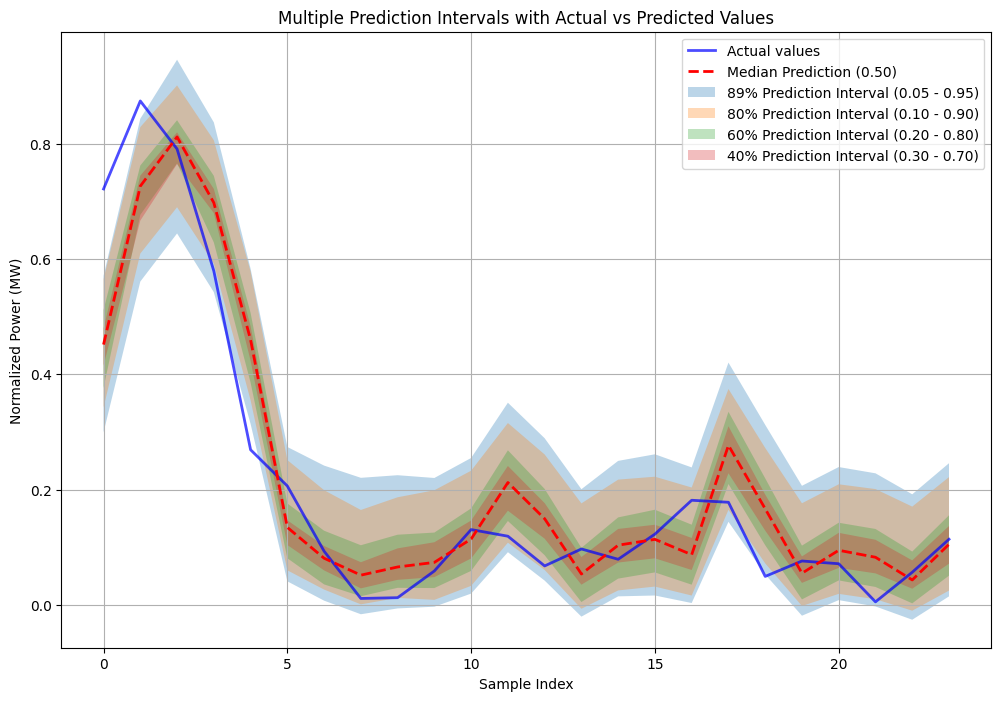

In [63]:
# Function to plot multiple prediction intervals
def plot_multiple_prediction_intervals(y_test, pred_test, quantiles, subset_size=24):
    # Select subset of data for visualization
    y_test_subset = y_test[:subset_size]
    median_prediction = pred_test[0.50][:subset_size]  # Median quantile (0.50)

    # Define intervals as pairs of lower and upper quantiles
    intervals = [
        (0.05, 0.95),  # 90% prediction interval
        (0.10, 0.90),  # 80% prediction interval
        (0.20, 0.80),  # 60% prediction interval
        (0.30, 0.70),  # 40% prediction interval
    ]

    plt.figure(figsize=(12, 8))

    # Plot the actual values
    plt.plot(y_test_subset, label='Actual values', color='blue', alpha=0.7, linewidth=2)

    # Plot the median prediction
    plt.plot(median_prediction, label='Median Prediction (0.50)', color='red', linestyle='--', linewidth=2)

    # Plot prediction intervals
    for lower_quantile, upper_quantile in intervals:
        # Extract lower and upper bounds and flatten them to 1D
        lower_bound = pred_test[lower_quantile][:subset_size].flatten()
        upper_bound = pred_test[upper_quantile][:subset_size].flatten()

        plt.fill_between(
            range(subset_size),
            lower_bound,
            upper_bound,
            alpha=0.3,
            label=f'{int((upper_quantile - lower_quantile) * 100)}% Prediction Interval ({lower_quantile:.2f} - {upper_quantile:.2f})'
        )

    # Add titles and labels
    plt.title('Multiple Prediction Intervals with Actual vs Predicted Values')
    plt.xlabel('Sample Index')
    plt.ylabel('Normalized Power (MW)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
plot_multiple_prediction_intervals(y_test, pred_test, quantiles)